In [169]:
# import all modules
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from PRIS import * 
import copy



In [170]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Construct obseration operator (load PSF)

In [2]:
# construct observation operator.
 # load psf matrix
dpath = './test_data/psf.tif';
psf = io.imread(dpath)


# Load observation and set blur

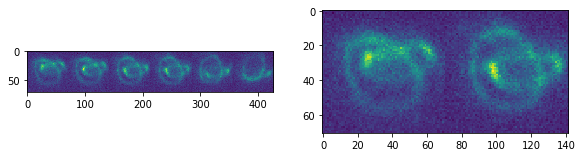

In [40]:
# load observation
data_path = './test_data';
f = 'obsStack.tif';
fov = io.imread(data_path + '/' + f)
fov.shape
plt.figure(figsize=(15,5));
plt.subplot(131)
plt.imshow(fov[[1,3,5,6,10,15],:,:].reshape(6*fov.shape[1],fov.shape[2]).T)

blur1 = fov[1,:,:];
blur2 = fov[6,:,:];
#100 nm step interval so there is a 500 nm separation. 20 layer separation between psf steps.
blur = np.concatenate([blur1, blur2]).reshape(2*71,71);
plt.subplot(132)
plt.imshow(blur.T)

# Initialize PRIS 

In [187]:
# get a PyPRIS object:
%reload_ext autoreload
pypris = PyPRIS()
pypris.observation = blur.ravel()
pypris.current_candidates_intervals = list([1, 4, 4])  # initialize the first intervals of neighboring candidate voxels.

# decide candidates for the first PRIS iteration. PRIS #0:
range_ind0 = np.arange(-36, 36, pypris.current_candidates_intervals[0]) # seems like for DH psf, use finnest intervals for the thickness dimension is better.
range_ind1 = np.arange(5,   66, pypris.current_candidates_intervals[1])
range_ind2 = np.arange(5,   66, pypris.current_candidates_intervals[2])

# initialize the first pool of candidates with the current candidate intervals.
pypris.current_candidates = list()  # current pool of candidates.
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            pypris.current_candidates.append([i0,i1,i2])

# set a check mark for pypris:
pypris.set_check_mark()

In [188]:
pypris.show_attributes()

name:  PyPRIS object
positivity:  True
observation:  [141 148 131 ... 148 150 127]
current_ReF:  []
current_relReF:  []
current_PRIS_ItN:  [0]
current_A:  []
current_candidates
current_candidates_intervals:  [1, 4, 4]
current_check_mark_id:  1
hist_candidates
hist_candidates_intervals:  [[1, 4, 4]]
hist_PRIS_ItN:  [[0]]
hist_check_mark_id:  [0]
observator:  None


In [189]:
# define a observer [from one candidate, to one observation]

# initialize an observer
observer = ObserveStation()

# setup this observer to perform biplane observation
observer.observe_biplane_prep(psf, single_image_size = blur1.shape, \
                           deltaz_plane1 = -10, \
                           deltaz_plane2 = 10, \
                           psfz0 = 106, \
                           observer_debugger = False, \
                           observer_edge_padding = True)

# set the pypris observation to be the biplane observation method that belongs to this observer.
pypris.observe = observer.observe_biplane

# PRIS iteration # 0

In [190]:
# construct sensing matrix,
pypris.generate_sensing_mx()


In [191]:
pypris.show_attributes()

name:  PyPRIS object
positivity:  True
observation:  [141 148 131 ... 148 150 127]
current_ReF:  []
current_relReF:  []
current_PRIS_ItN:  [0]
current_A:  [[5.63000000e+02 7.65000000e+02 8.29000000e+02 ... 4.17194444e+02
  4.17194444e+02 1.00000000e+00]
 [5.53000000e+02 7.05000000e+02 8.52000000e+02 ... 4.17194444e+02
  4.17194444e+02 1.00000000e+00]
 [5.62000000e+02 6.38000000e+02 8.48000000e+02 ... 4.17194444e+02
  4.17194444e+02 1.00000000e+00]
 ...
 [4.39527778e+02 4.39527778e+02 4.39527778e+02 ... 1.01700000e+03
  1.06500000e+03 1.00000000e+00]
 [4.39527778e+02 4.39527778e+02 4.39527778e+02 ... 8.95000000e+02
  1.10900000e+03 1.00000000e+00]
 [4.39527778e+02 4.39527778e+02 4.39527778e+02 ... 7.47000000e+02
  1.10100000e+03 1.00000000e+00]]
current_candidates
current_candidates_intervals:  [1, 4, 4]
current_check_mark_id:  1
hist_candidates
hist_candidates_intervals:  [[1, 4, 4]]
hist_PRIS_ItN:  [[0]]
hist_check_mark_id:  [0]
observator:  None
observe:  <bound method ObserveStation

# Recovery

In [29]:
%reload_ext autoreload

Successfully created Scratch directory ../../PyPRIS_Scratch/ 
Successfully wrote sensing matrix to directory ../../PyPRIS_Scratch/saved_objects 
Successfully created Object-saving directory ../../PyPRIS_Scratch/saved_objects 
Successfully created Debug directory ../../PyPRIS_Scratch/debug_output 


C:\Users\china\Desktop\Research\PyPRIS\PyPRIS_notebooks\PRIS.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  self.hist_resDrop.append((self.hist_res[it_count] - self.hist_res[it_count - 1]) / self.hist_res[it_count - 1])


intermediate output it#1


C:\Users\china\Desktop\Research\PyPRIS\PyPRIS_notebooks\PRIS.py:552: RuntimeWarning: divide by zero encountered in log
  plt.plot(self.iterations, np.log(self.hist_res), '.')
C:\Users\china\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


TypeError: 'NoneType' object is not subscriptable

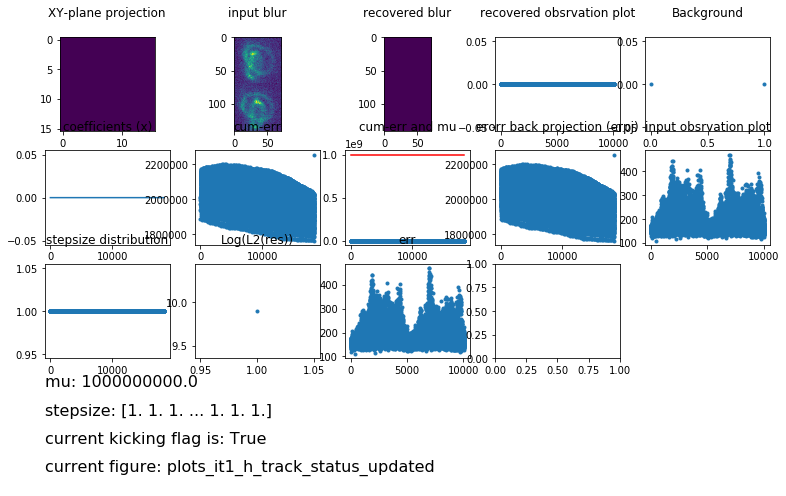

In [193]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
pypris.current_A[:,len(pypris.current_candidates)] = 580
Anorm = pypris.current_A/500
a = LinBreg(Anorm,np.zeros(Anorm.shape[1]),pypris.observation.ravel(), 1)
a.debug = True
a.deep_debug = False
a.mu = 1000000000
a.obs_dim0 = blur.shape[0]
a.obs_dim1 = blur.shape[1]

#a.stepsize = 1e-6
a.alpha = 1e-8
a.maxit = 10000 # maximum iteration steps.
a.debug_it_int = 1000
a.it_check_rem = 1
a.kick.ints = 10
a.kick.flag = True
a.kick.thres = 1e-3
a.range_ind0 = range_ind0
a.range_ind1 = range_ind1
a.range_ind2 = range_ind2
a.save_obj_int = 1000
a.save = True

a.candidate_coords = pypris.current_candidates
a.candidate_intervals = pypris.current_candidates_intervals

a.get_ready()
a.go()

# PRIS refinement 
   ## refine coordinates of candidates

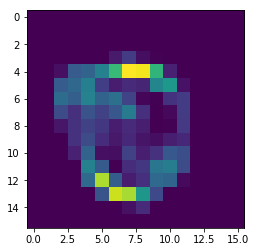

In [4]:
a_rec = loadPyPRIS(1,1001)
plt.imshow(np.mean(a_rec.x[0:a_rec.x.size-1].reshape(a_rec.range_ind0.size,a_rec.range_ind1.size,a_rec.range_ind2.size),axis=0))


In [6]:
a_rec.range_ind2.size

16

In [5]:
# decide candidates 
range_ind0 = np.arange(-36,36)
range_ind1 = np.arange(5,66,4)
range_ind2 = np.arange(5,66,4)
candidate_locs = list()
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            candidate_locs.append([i0,i1,i2])
            
a = a_rec
non_zero_inds = np.argwhere(a.x[0:len(a.x)-1]>0)
non_zero_coordinates = [candidate_locs[i] for i in list(non_zero_inds.ravel())]
non_zero_inds.size

previous_interval = 4
current_interval = previous_interval/2

new_coords = list()
for i in non_zero_coordinates:    
    extra_coords=[[i[0], i[1] - current_interval/2*3, i[2] - current_interval/2*3],\
                  [i[0], i[1] - current_interval/2*3, i[2] - current_interval/2  ],\
                  [i[0], i[1] - current_interval/2*3, i[2] + current_interval/2  ],\
                  [i[0], i[1] - current_interval/2*3, i[2] + current_interval/2*3],\
                  [i[0], i[1] - current_interval/2,   i[2] - current_interval/2*3],\
                  [i[0], i[1] - current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] - current_interval/2,   i[2] + current_interval/2  ],\
                  [i[0], i[1] - current_interval/2,   i[2] + current_interval/2*3],\
                  [i[0], i[1] + current_interval/2*3, i[2] - current_interval/2*3],\
                  [i[0], i[1] + current_interval/2*3, i[2] - current_interval/2  ],\
                  [i[0], i[1] + current_interval/2*3, i[2] + current_interval/2  ],\
                  [i[0], i[1] + current_interval/2*3, i[2] + current_interval/2*3],\
                  [i[0], i[1] + current_interval/2,   i[2] - current_interval/2*3],\
                  [i[0], i[1] + current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] + current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] + current_interval/2*3]] # bisection only in x-dimesnion and y-dimension. no bisection in z.
    
    for i1 in extra_coords:
        if i1 not in new_coords:
            new_coords.append(i1)

In [6]:
candidate_locs = copy.deepcopy(new_coords)

# construct sensing matrix

In [7]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-10
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+10
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

## Refinement recovery

In [ ]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
A[:,len(candidate_locs)] = 580
Anorm = A/500
a = LinBreg(Anorm,np.zeros(A.shape[1]),blur.ravel(),2)
a.debug = True
a.deep_debug = False
a.mu = 1000000000
a.obs_dim0 = blur.shape[0]
a.obs_dim1 = blur.shape[1]

#a.stepsize = 1e-6
a.alpha = 1e-8
a.maxit = 3000 # maximum iteration steps.
a.debug_it_int = 1000
a.it_check_rem = 1
a.kick.ints = 10
a.kick.flag = True
a.kick.thres = 1e-3
a.range_ind0 = range_ind0
a.range_ind1 = range_ind1
a.range_ind2 = range_ind2
a.save_obj_int = 1000
a.save = False


a.candidate_coords = candidate_locs
a.candidate_intervals = [1,2,2]

a.getready()
a.go()

Successfully created Scratch directory ../../PyPRIS_Scratch/ 
Successfully created Debug directory ../../PyPRIS_Scratch/debug_output 
intermediate output it#1


C:\Users\wxjpp\Desktop\PyPRIS-xingjia\PyPRIS_notebooks\PRIS.py:488: RuntimeWarning: divide by zero encountered in double_scalars
  self.hist_resDrop.append((self.hist_res[it_count] - self.hist_res[it_count-1])/self.hist_res[it_count-1])
C:\Users\wxjpp\Desktop\PyPRIS-xingjia\PyPRIS_notebooks\PRIS.py:458: RuntimeWarning: divide by zero encountered in log
  plt.plot(self.iterations, np.log(self.hist_res), '.')


intermediate output it#1001


In [32]:
a.save = True
it = a.iterations[len(a.iterations)-1] + 100
a.save_obj(it+1, it)

In [11]:
len(candidate_locs)

15452

In [12]:
len(a.x)

15453